In [9]:
import sys
sys.path.append('..')

from deepgraph.utils.logging import log
from deepgraph.utils.common import batch_parallel, ConfigMixin, shuffle_in_unison_inplace, pickle_dump
from deepgraph.utils.image import batch_pad_mirror
from deepgraph.constants import *
from deepgraph.conf import rng

from deepgraph.pipeline import Processor, Packet

In [10]:
from deepgraph.nn.init import *
from deepgraph.node import Node

# Custom loss node
class MaskedLogLoss(Node):
    """
    Compute log scale invariant error for depth prediction
    """
    def __init__(self, graph, name, config={}):
        """
        Constructor
        :param graph: Graph
        :param name: String
        :param config: Dict
        :return: Node
        """
        super(MaskedLogLoss, self).__init__(graph, name, config=config)
        self.is_loss = True

    def setup_defaults(self):
        super(MaskedLogLoss, self).setup_defaults()
        self.conf_default("loss_weight", 1.0)
        self.conf_default("lambda", 0.5)
        self.conf_default("label_index", 1)
        self.conf_default("loss_type", "spatial_grad")

    def alloc(self):
            if len(self.inputs) != 2:
                raise AssertionError("This node needs exactly two inputs to calculate loss.")
            self.output_shape = (1,)
            # Print debug information
            print "LOGLOSS: Input 0 name: %s" % self.inputs[0].name
            print "LOGLOSS: Input 1 name: %s" % self.inputs[1].name
            

    def forward(self):
            # Define our forward function
            if self.conf("label_index") == 1:
                pred = self.inputs[0].expression
                target = self.inputs[1].expression
                print "LOGLOSS Target is node: %s" % self.inputs[1].name
            else:
                pred = self.inputs[1].expression
                target = self.inputs[0].expression
                print "LOGLOSS Target is node: %s" % self.inputs[0].name
            """
            # Compute a mask which removes invalid values or 0
            null_mask = T.gt(target,0)
            # Compute a mask which removes the max values of a depth image
            max_mask = T.lt(target, T.max(target))
            # Mask out min
            min_mask = T.gt(target, T.min(target))
            # Combine masks
            mask = null_mask * max_mask * min_mask
            # Now we compute the log of the input data stream, but neglect invalid values
            log_target = T.switch(mask, T.log(target),0)
            # We also apply the mask to our predictions in order to avoid computation of gradients on invalid pixels
            masked_pred = mask * pred
            # We compute the difference here to construct l_2 norm later in log space, neglecting invalid pixels
            diff = log_target - masked_pred
            # We also have to compute the mean only on valid pixels, so we need the number of valid pixels
            n_valid = mask.sum()
            l = self.conf("lambda")
            # Finally compute the scale invariant error 
            self.expression = T.sum(diff**2) / n_valid - ((l / (n_valid**2)) * (T.sum(diff)**2))
            """
            l_type = self.conf("loss_type")
            if l_type is "euclidean":
                # Flatten input to make calc easier
                pred = pred.flatten(2)
                target = target.flatten(2)
                # Compute mask
                mask = T.gt(target,0)
                # Compute n of valid pixels
                n_valid = T.sum(mask, axis=1)
                # Apply mask and NO transform
                m_pred = pred * mask
                m_t = T.switch(mask, target,0)
                d = m_pred - m_t
                l = 0
                # Define cost
                self.expression = (T.sum(n_valid * T.sum(d**2, axis=1)) - l*T.sum(T.sum(d, axis=1)**2))/ T.maximum(T.sum(n_valid**2), 1)
            elif l_type is "scale_invariant":
                # Flatten input to make calc easier
                pred = pred.flatten(2)
                target = target.flatten(2)
                # Compute mask
                mask = T.gt(target,0)
                # Compute n of valid pixels
                n_valid = T.sum(mask, axis=1)
                # Apply mask and log transform
                m_pred = pred * mask
                m_t = T.switch(mask, T.log(target),0)
                d = m_pred - m_t
                # Pull lambda
                l = self.conf("lambda")
                # Define cost
                self.expression = (T.sum(n_valid * T.sum(d**2, axis=1)) - l*T.sum(T.sum(d, axis=1)**2))/ T.maximum(T.sum(n_valid**2), 1)
            elif l_type is "spatial_grad":
                # Flatten input to make calc easier
                pred_v = pred.flatten(2)
                target_v = target.flatten(2)
                # Compute mask
                mask = T.gt(target_v,0)
                # Compute n of valid pixels
                n_valid = T.sum(mask, axis=1)
                # Apply mask and log transform
                m_pred = pred_v * mask
                m_t = T.switch(mask, T.log(target_v),0)
                d = m_pred - m_t
                # Pull lambda
                l = self.conf("lambda")
                # Define scale invariant cost
                scale_invariant_cost = (T.sum(n_valid * T.sum(d**2, axis=1)) - l*T.sum(T.sum(d, axis=1)**2))/ T.maximum(T.sum(n_valid**2), 1)
                
                # Add spatial gradient components from D. Eigen DNL 
                
                # Squeeze in case 
                if pred.ndim == 4:
                    pred = pred[:,0,:,:]
                if target.ndim == 4:
                    target = target[:,0,:,:]
                # Mask in tensor form
                mask_tensor = T.gt(target,0)
                # Project into log space
                target = T.switch(mask_tensor, T.log(target),0)
                # Stepsize
                h = 1
                # Compute spatial gradients symbolically
                p_di = (pred[:,h:,:] - pred[:,:-h,:]) * (1 / np.float32(h))
                p_dj = (pred[:,:,h:] - pred[:,:,:-h]) * (1 / np.float32(h))
                t_di = (target[:,h:,:] - target[:,:-h,:]) * (1 / np.float32(h))
                t_dj = (target[:,:,h:] - target[:,:,:-h]) * (1 / np.float32(h))
                m_di = T.and_(mask_tensor[:,h:,:], mask_tensor[:,:-h,:])
                m_dj = T.and_(mask_tensor[:,:,h:], mask_tensor[:,:,:-h])
                # Define spatial grad cost
                grad_cost = T.sum(m_di * (p_di - t_di)**2) / T.sum(m_di) + T.sum(m_dj * (p_dj - t_dj)**2) / T.sum(m_dj)
                # Compute final expression
                self.expression = scale_invariant_cost + grad_cost
            else:
                raise AssertionError("Unknown losstype %s" % l_type)
            

            
            



In [11]:
# Input data transformer
class Transformer(Processor):
    """
    Apply online random augmentation.
    """
    def __init__(self, name, shapes, config, buffer_size=10):
        super(Transformer, self).__init__(name, shapes, config, buffer_size)
        self.mean = None

    def init(self):
        if self.conf("mean_file") is not None:
            self.mean = np.load(self.conf("mean_file")).astype(np.float32)
        elif self.conf("mean") is not None:
            self.mean = self.conf("mean")
        else:
            log("Transformer - No mean file specified.", LOG_LEVEL_WARNING)

    def process(self):
        packet = self.pull()
        # Return if no data is there
        if not packet:
            return False
        # Unpack
        data, label = packet.data
        # Copy
        data = data.copy()
        label = label.copy()
        # Do processing
        log("Transformer - Processing data", LOG_LEVEL_VERBOSE)
        
        h = 240
        w = 320
        
        start = time.time()
        # Mean
        if packet.phase == PHASE_TRAIN or packet.phase == PHASE_VAL:
            data = data.astype(np.float32)
            if self.mean is not None:
                std = self.conf("std_norm")
                for idx in range(data.shape[0]):
                    # Subtract mean
                    data[idx] = data[idx] - self.mean
                    if std is not None:
                        data[idx] =  data[idx] * std

            if self.conf("offset") is not None:
                label -= self.conf("offset")

        if packet.phase == PHASE_TRAIN:
             # Do elementwise operations
            data_old = data
            label_old = label
            data = np.zeros((data_old.shape[0], data_old.shape[1], h, w), dtype=np.float32)
            label = np.zeros((label_old.shape[0], h, w), dtype=np.float32)
            for idx in range(data.shape[0]):
                # Rotate
                # We rotate before cropping to be able to get filled corners
                # Maybe even adjust the border after rotating
                deg = np.random.randint(-5,6)
                # Operate on old data. Careful - data is already in float so we need to normalize and rescale afterwards
                # data_old[idx] = 255. * rotate_transformer_rgb_uint8(data_old[idx] * 0.003921568627, deg).astype(np.float32)
                # label_old[idx] = rotate_transformer_scalar_float32(label_old[idx], deg)
                
                # Take care of any empty areas, we crop on a smaller surface depending on the angle
                # TODO Remove this once loss supports masking

                shift = 0 #np.tan((deg/180.) * math.pi)
                # Random crops
                cy = rng.randint(data_old.shape[2] - h - shift, size=1)
                cx = rng.randint(data_old.shape[3] - w - shift, size=1)
                

                data[idx] = data_old[idx, :, cy:cy+h, cx:cx+w]
                label[idx] = label_old[idx, cy:cy+h, cx:cx+w]
                
                # Flip horizontally with probability 0.5
                p = rng.randint(2)
                if p > 0:
                    data[idx] = data[idx, :, :, ::-1]
                    label[idx] = label[idx, :, ::-1]

                # RGB we mult with a random value between 0.8 and 1.2
                r = rng.randint(80,121) / 100.
                g = rng.randint(80,121) / 100.
                b = rng.randint(80,121) / 100.
                data[idx, 0] = data[idx, 0] * r
                data[idx, 1] = data[idx, 1] * g
                data[idx, 2] = data[idx, 2] * b
                
                
            # Shuffle
            data, label = shuffle_in_unison_inplace(data, label)
            
        elif packet.phase == PHASE_VAL:
            # Center crop
            cy = (data.shape[2] - h) // 2
            cx = (data.shape[3] - w) // 2
            data = data[:, :, cy:cy+h, cx:cx+w]
            label = label[:, cy:cy+h, cx:cx+w]
            
        end = time.time()
        log("Transformer - Processing took " + str(end - start) + " seconds.", LOG_LEVEL_VERBOSE)
        # Try to push into queue as long as thread should not terminate
        self.push(Packet(identifier=packet.id, phase=packet.phase, num=2, data=(data, label)))
        return True

    def setup_defaults(self):
        super(Transformer, self).setup_defaults()
        self.conf_default("mean_file", None)
        self.conf_default("mean", None)
        self.conf_default("offset", None)
        self.conf_default("std_norm", 1.0)

In [12]:
# Raw data collector
from os import listdir
from os.path import isfile, join
import h5py, math

class NYULargeLoader(Processor):
    """
    Processor class to asynchronously load data in chunks and prepare it for later stages
    """
    def __init__(self, name, shapes, config, buffer_size=10):
        super(NYULargeLoader, self).__init__(name, shapes, config, buffer_size)
        self.permutation = None
        self.idx = 0

    def setup_defaults(self):
        super(NYULargeLoader, self).setup_defaults()
        self.conf_default("dataset", None)
        self.conf_default("chunk_size", 320)

    def init(self):
        # Collect all files that we got inside that dir
        self.ds = self.conf("dataset")
        self.cs = self.conf("chunk_size")
        
        # Check shapes
        f = h5py.File(self.ds)
        self.len = f["images"].shape[0]
        f.close()
        # Create an initial permutation list
        self.permutation = np.random.permutation(self.len)

    def process(self):
        """
        Read elements from the database in packes specified by "chunk_size". Feed each packet to the top processor
        in case its entry queue is not full
        :return: Bool
        """
        if self.top is not None:
            packet = self.pull()
            if packet is None:
                return False
            # Fetch start
            if packet.phase == PHASE_VAL:   # no VAL, lol....
                return True
            
            # Grab a permutation from out container
            upper = min(self.len, self.idx + self.cs)
            perm = self.permutation[self.idx:upper]
            perm = np.sort(perm)
            # Load the data from disk
            f = h5py.File(self.ds)
            data = np.array(f["images"][perm,:,:,:]).copy()
            label = np.array(f["depths"][perm,:,:]).copy()
            
            if self.idx + self.cs > self.len:
                self.idx = 0
                # Recreate permutation list
                self.permutation = np.random.permutation(self.len)
            else:
                self.idx += self.cs
                
                
            # Close the handle
            f.close()
            # Fetch end
            self.push(Packet(identifier=packet.id,
                             phase=packet.phase,
                             num=2,
                             data=(data, label)))
            return True
        else:
            # No top node found, enter spin wait time
            return False






In [ ]:
from theano.tensor.nnet import relu

from deepgraph.graph import *
from deepgraph.nn.core import *
from deepgraph.nn.conv import *
from deepgraph.nn.loss import *
from deepgraph.solver import *
from deepgraph.nn.init import *

from deepgraph.pipeline import Optimizer, H5DBLoader, Pipeline

BN_DISABLED = False

def build_u_graph():
    # Disable CUDNN
    # TODO Remove
    Conv2D.use_cudnn = False
    Pool.use_cudnn = False
    
    graph = Graph("u_depth")

    """
    Inputs
    """
    data = Data(graph, "data", T.ftensor4, shape=(-1, 3, 240, 320))
    label = Data(graph, "label", T.ftensor3, shape=(-1, 1, 240, 320), config={
        "phase": PHASE_TRAIN
    })
    """
    Contractive part
    """
    conv_1 = Conv2D(
        graph,
        "conv_1",
        config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_2 = Conv2D(
        graph,
        "conv_2",
        config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": None,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    bn_2 = BN(graph, "bn_2", config={"nonlinearity": relu, "disable": BN_DISABLED})
    pool_2 = Pool(graph, "pool_2", config={
        "kernel": (2, 2)
    })
    conv_3 = Conv2D(
        graph,
        "conv_3",
        config={
            "channels": 128,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_4 = Conv2D(
        graph,
        "conv_4",
        config={
            "channels": 128,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": None,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    bn_4 = BN(graph, "bn_4", config={"nonlinearity": relu, "disable": BN_DISABLED})
    pool_4 = Pool(graph, "pool_4", config={
        "kernel": (2, 2)
    })

    conv_5 = Conv2D(
        graph,
        "conv_5",
        config={
            "channels": 256,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_6 = Conv2D(
        graph,
        "conv_6",
        config={
            "channels": 256,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": None,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    bn_6 = BN(graph, "bn_6", config={"nonlinearity": relu, "disable": BN_DISABLED})
    pool_6 = Pool(graph, "pool_6", config={
        "kernel": (2, 2)
    })

    conv_7 = Conv2D(
        graph,
        "conv_7",
        config={
            "channels": 512,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_8 = Conv2D(
        graph,
        "conv_8",
        config={
            "channels": 512,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": None,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    #bn_8 = BN(graph, "bn_8", config={"nonlinearity": relu, "disable": BN_DISABLED})
    pool_8 = Pool(graph, "pool_8", config={
        "kernel": (2, 2)
    })
    fl = Flatten(graph, "fl",config={
            "dims": 2
    })
    fc_8 = Dense(graph, "fc_8", config={
        "out": 4096,
        "activation": None,
        "weight_filler": xavier(),
        "bias_filler": constant(0.01)
    })
    fc_9 = Dense(graph, "fc_9", config={
        "out": 19200,
        "activation": None,
        "weight_filler": xavier(),
        "bias_filler": constant(0.01)
    })
    rs_10 = Reshape(graph, "rs_10", config={
        "shape": (-1, 64, 15, 20)
    })
    """
    Expansive path
    """
    #bn_11 = BN(graph, "bn_11", config={"nonlinearity": relu, "disable": BN_DISABLED})
    up_11 = Upsample(graph, "up_11", config={
        "kernel": (2, 2)
    })
    conv_11 = Conv2D(
        graph,
        "conv_11",
        config={
            "channels": 512,
            "kernel": (3, 3),
            "border_mode": 1,
            "weight_filler": xavier(),
            "bias_filler": constant(0)
        }
    )
    conv_12 = Conv2D(
        graph,
        "conv_12",
        config={
            "channels": 512,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_13 = Conv2D(
        graph,
        "conv_13",
        config={
            "channels": 512,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": None,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    bn_13 = BN(graph, "bn_13", config={"nonlinearity": relu, "disable": BN_DISABLED})
    up_14 = Upsample(graph, "up_14", config={
        "kernel": (2, 2)
    })
    conv_14 = Conv2D(
        graph,
        "conv_14",
        config={
            "channels": 256,
            "kernel": (3, 3),
            "border_mode": 1,
            "weight_filler": xavier(),
            "bias_filler": constant(0)
        }
    )
    conv_15 = Conv2D(
        graph,
        "conv_15",
        config={
            "channels": 256,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_16 = Conv2D(
        graph,
        "conv_16",
        config={
            "channels": 256,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": None,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    bn_16 = BN(graph, "bn_16", config={"nonlinearity": relu, "disable": BN_DISABLED})
    up_17 = Upsample(graph, "up_17", config={
        "kernel": (2, 2)
    })
    conv_17 = Conv2D(graph, "conv_17", config={
            "channels": 128,
            "kernel": (3, 3),
            "border_mode": 1,
            "weight_filler": xavier(),
            "bias_filler": constant(0)
    })
    conv_18 = Conv2D(
        graph,
        "conv_18",
        config={
            "channels": 128,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_19 = Conv2D(
        graph,
        "conv_19",
        config={
            "channels": 128,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": None,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    bn_19 = BN(graph, "bn_19", config={"nonlinearity": relu, "disable": BN_DISABLED})
    up_20 = Upsample(graph, "up_20", config={
        "mode": "constant",
        "kernel": (2, 2)
    })
    conv_20 = Conv2D(graph, "conv_20", config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": 1,
            "weight_filler": xavier(),
            "bias_filler": constant(0)
    })
    conv_21 = Conv2D(
        graph,
        "conv_21",
        config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_22 = Conv2D(
        graph,
        "conv_22",
        config={
            "channels": 64,
            "kernel": (3, 3),
            "border_mode": (1, 1),
            "activation": relu,
            "weight_filler": xavier(gain="relu"),
            "bias_filler": constant(0)
        }
    )
    conv_23 = Conv2D(
        graph,
        "conv_23_with_bias",
        config={
            "channels": 1,
            "kernel": (1, 1),
            "activation": None,
            "weight_filler": xavier(),
            "bias_filler": constant(0),
            "is_output": True
        }
    )

    """
    Feed forward nodes
    """
    

    concat_20 = Concatenate(graph, "concat_20", config={
        "axis": 1
    })

    

    concat_17 = Concatenate(graph, "concat_17", config={
        "axis": 1
    })

    
    concat_14 = Concatenate(graph, "concat_14", config={
        "axis": 1
    })

    

    concat_11 = Concatenate(graph, "concat_11", config={
        "axis": 1
    })


    """
    Losses / Error
    """
    loss = MaskedLogLoss(graph, "loss")
    project = Function(graph, "proj_log", config={
        "expression": lambda x: T.exp(x),
        "phase": PHASE_TRAIN
    })
    error = MSE(graph, "mse", config={
        "root": True,
        "is_output": True,
        "phase": PHASE_TRAIN
    })


    """
    Make connections
    """
    data.connect(conv_1)
    conv_1.connect(conv_2)
    conv_2.connect(concat_20)
    conv_2.connect(bn_2)
    bn_2.connect(pool_2)
    pool_2.connect(conv_3)
    conv_3.connect(conv_4)
    conv_4.connect(concat_17)
    conv_4.connect(bn_4)
    bn_4.connect(pool_4)
    pool_4.connect(conv_5)
    conv_5.connect(conv_6)
    conv_6.connect(concat_14)
    conv_6.connect(bn_6)
    bn_6.connect(pool_6)
    pool_6.connect(conv_7)
    conv_7.connect(conv_8)
    conv_8.connect(concat_11)
    conv_8.connect(pool_8)
    #bn_8.connect(pool_8)
    pool_8.connect(fl)
    fl.connect(fc_8)
    fc_8.connect(fc_9)
    fc_9.connect(rs_10)
    rs_10.connect(up_11)
    #bn_11.connect(up_11)
    up_11.connect(conv_11)
    conv_11.connect(concat_11)
    concat_11.connect(conv_12)
    conv_12.connect(conv_13)
    conv_13.connect(bn_13)
    bn_13.connect(up_14)
    up_14.connect(conv_14)
    conv_14.connect(concat_14)
    concat_14.connect(conv_15)
    conv_15.connect(conv_16)
    conv_16.connect(bn_16)
    bn_16.connect(up_17)
    up_17.connect(conv_17)
    conv_17.connect(concat_17)
    concat_17.connect(conv_18)
    conv_18.connect(conv_19)
    conv_19.connect(bn_19)
    bn_19.connect(up_20)
    up_20.connect(conv_20)
    conv_20.connect(concat_20)
    concat_20.connect(conv_21)
    conv_21.connect(conv_22)
    conv_22.connect(conv_23)
    
    # Make sure we connect the prediction first and then the loss to compute the log space properly
    # -> Pred index defaults to 0 for masked log loss
    conv_23.connect(loss)
    label.connect(loss)

    conv_23.connect(project)
    label.connect(error)
    project.connect(error)

    return graph

In [ ]:
from deepgraph.conf import set_log_level
if __name__ == "__main__":
    # set_log_level(LOG_LEVEL_VERBOSE)
    batch_size = 2
    chunk_size = 5*batch_size
    transfer_shape = ((chunk_size, 3, 240, 320), (chunk_size, 240, 320))

    g = build_u_graph()

    # Build the training pipeline
    db_loader = NYULargeLoader("db", ((chunk_size, 3, 480, 640), (chunk_size, 1, 480, 640)), config={
        "dataset": "/home/sebastianschlecht/depth_data/nyu_v1_large.hdf5",
        "chunk_size": chunk_size
    })
    transformer = Transformer("tr", transfer_shape, config={
        # Const mean this time
        "mean_file": "/home/sebastianschlecht/depth_data/nyu_v1_large.npy",
        # 1 / sqrt(var(data))
        "std_norm": 1.0 / 68.585375331125292
    })
    optimizer = Optimizer("opt", g, transfer_shape, config={
        "batch_size":  batch_size,
        "chunk_size": chunk_size,
        "learning_rate": 0.1, # for step 1
        # "learning_rate": 0.001, # for step 2
        "momentum": 0.9,
        "weight_decay": 0.0005,
        "print_freq": 20,
        "lr_policy": "step",
        "step_size": 30000,
        "save_freq": 30000,
        "warmup": False,
        "warmup_step_size": 2000,
        "weights": "/home/sebastianschlecht/depth_models/vnet2_logloss_raw_bn_iter_49997.zip",
        "save_prefix": "/home/sebastianschlecht/depth_models/vnet2_logloss_raw_bn"
    })

    p = Pipeline(config={
        "validation_frequency": 50,
        "cycles": 30000
    })
    p.add(db_loader)
    p.add(transformer)
    p.add(optimizer)
    p.run()





[2016-05-23 12:01:02] INFO: Graph - Loading parameters from file '/home/sebastianschlecht/depth_models/vnet2_logloss_raw_bn_iter_49997.zip'
[2016-05-23 12:01:02] INFO: Graph - Setting up graph
[2016-05-23 12:01:02] INFO: Node - data has shape (-1, 3, 240, 320)
[2016-05-23 12:01:02] INFO: Node - label has shape (-1, 1, 240, 320)
[2016-05-23 12:01:02] INFO: Node - conv_1 has shape (-1, 64, 240, 320)
[2016-05-23 12:01:02] INFO: Node - conv_2 has shape (-1, 64, 240, 320)
[2016-05-23 12:01:02] INFO: Node - bn_2 has shape (-1, 64, 240, 320)
[2016-05-23 12:01:02] INFO: Node - pool_2 has shape (-1, 64, 120, 160)
[2016-05-23 12:01:02] INFO: Node - conv_3 has shape (-1, 128, 120, 160)
[2016-05-23 12:01:02] INFO: Node - conv_4 has shape (-1, 128, 120, 160)
[2016-05-23 12:01:02] INFO: Node - bn_4 has shape (-1, 128, 120, 160)
[2016-05-23 12:01:02] INFO: Node - pool_4 has shape (-1, 128, 60, 80)
[2016-05-23 12:01:02] INFO: Node - conv_5 has shape (-1, 256, 60, 80)
[2016-05-23 12:01:02] INFO: Node -


# Load parameters & compile

In [6]:
g = build_u_graph()
g.load_weights("/home/sebastianschlecht/depth_models/vnet2_logloss_raw_bn_iter_49997.zip")
g.compile()

[2016-05-23 11:55:07] INFO: Graph - Loading parameters from file '/home/sebastianschlecht/depth_models/vnet2_logloss_raw_bn_iter_49997.zip'
[2016-05-23 11:55:07] INFO: Graph - Setting up graph
[2016-05-23 11:55:07] INFO: Node - data has shape (-1, 3, 240, 320)
[2016-05-23 11:55:07] INFO: Node - label has shape (-1, 1, 240, 320)
[2016-05-23 11:55:07] INFO: Node - conv_1 has shape (-1, 64, 240, 320)
[2016-05-23 11:55:07] INFO: Node - conv_2 has shape (-1, 64, 240, 320)
[2016-05-23 11:55:07] INFO: Node - bn_2 has shape (-1, 64, 240, 320)
[2016-05-23 11:55:07] INFO: Node - pool_2 has shape (-1, 64, 120, 160)
[2016-05-23 11:55:07] INFO: Node - conv_3 has shape (-1, 128, 120, 160)
[2016-05-23 11:55:07] INFO: Node - conv_4 has shape (-1, 128, 120, 160)
[2016-05-23 11:55:07] INFO: Node - bn_4 has shape (-1, 128, 120, 160)
[2016-05-23 11:55:07] INFO: Node - pool_4 has shape (-1, 128, 60, 80)
[2016-05-23 11:55:07] INFO: Node - conv_5 has shape (-1, 256, 60, 80)
[2016-05-23 11:55:07] INFO: Node -

# Infer on training or validation data

In [7]:
import h5py, numpy as np
f = h5py.File("/home/sebastianschlecht/depth_data/nyu_depth_combined_vnet2.hdf5")
b = int(f["images"].shape[0] * 0.9)
images = np.array(f["images"][b:])
depths = np.array(f["depths"][b:])
print images.shape
mean = np.load("/home/sebastianschlecht/depth_data/nyu_v1_large.npy")

(374, 3, 258, 344)


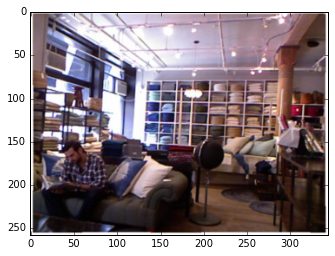

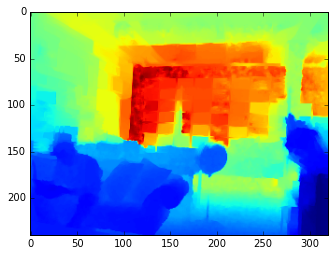

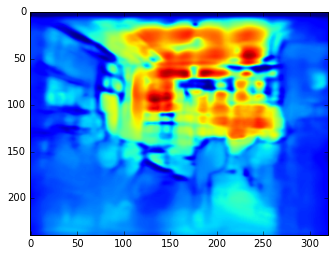

RMSE: 2.89285


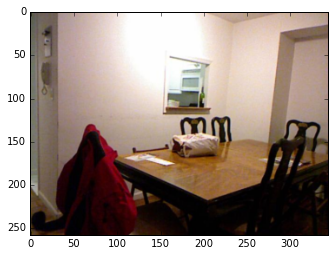

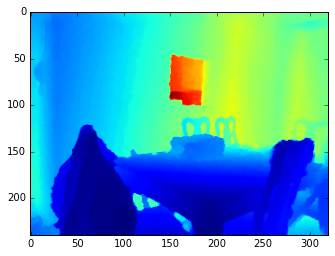

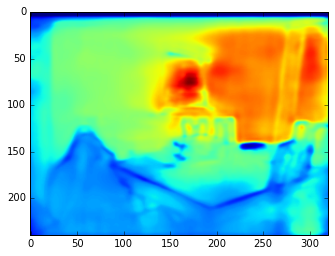

RMSE: 0.720359


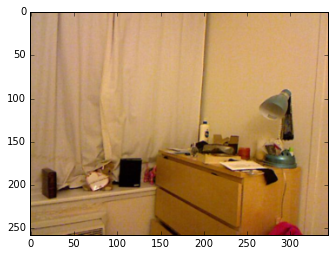

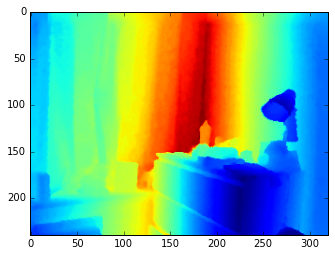

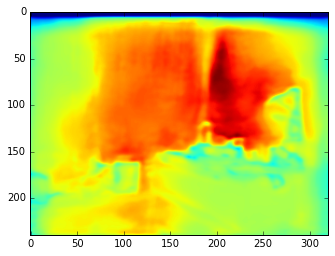

RMSE: 0.438536


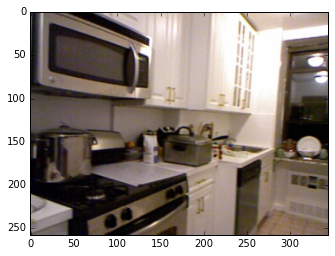

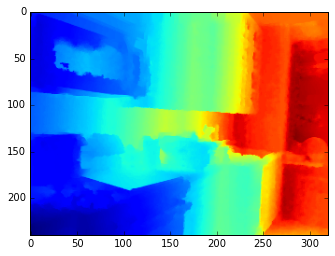

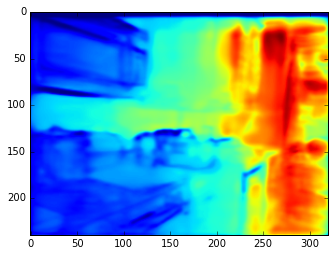

RMSE: 0.722606


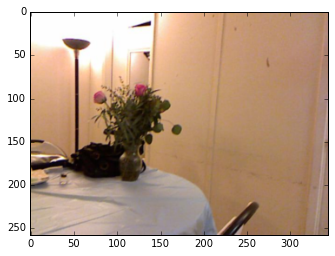

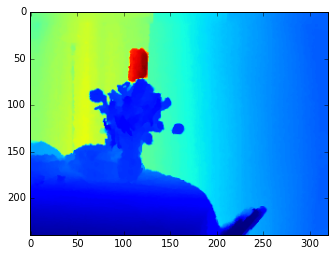

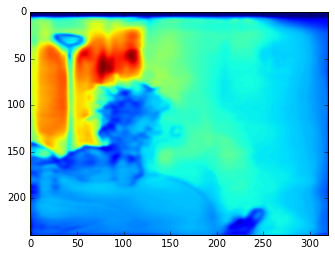

RMSE: 0.664171


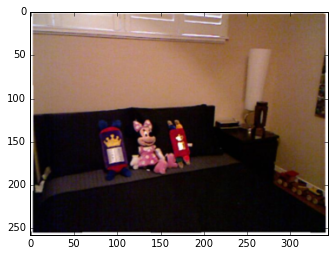

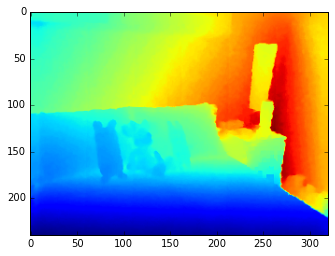

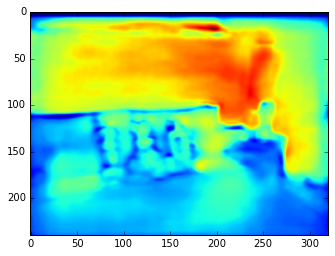

RMSE: 1.00168


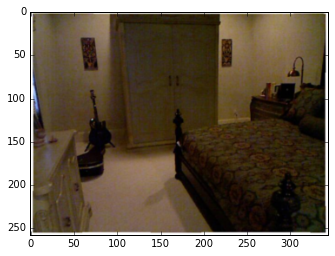

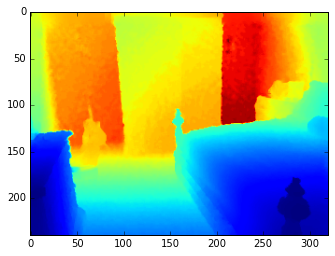

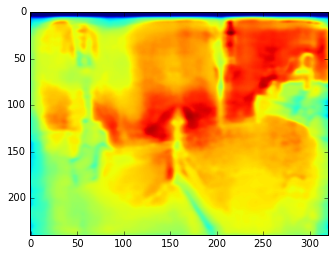

RMSE: 2.38239


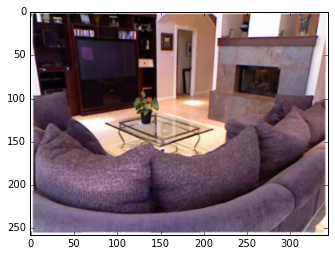

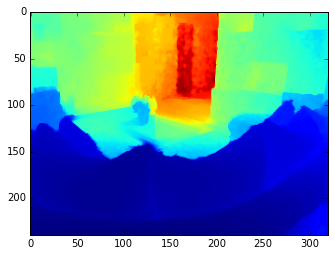

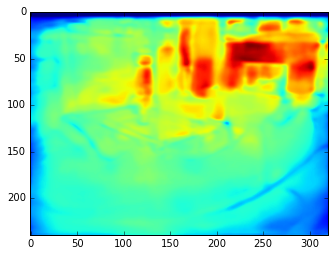

RMSE: 2.9967


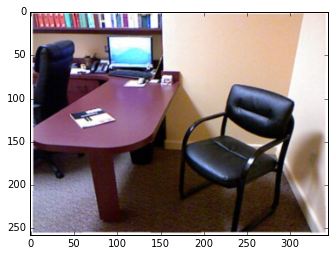

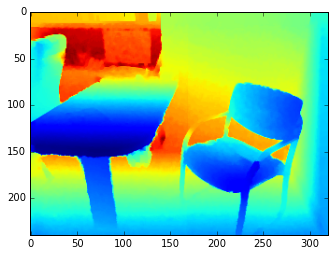

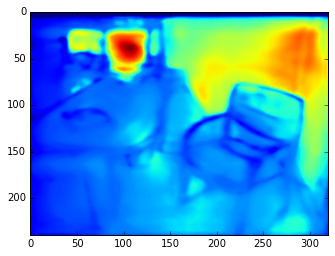

RMSE: 0.990292


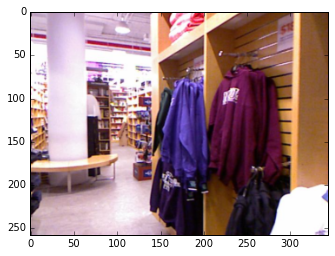

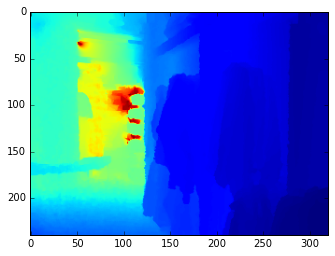

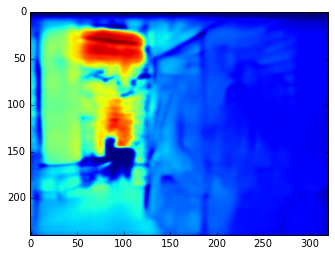

RMSE: 1.37749


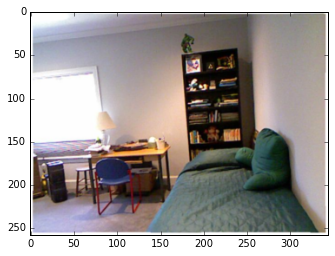

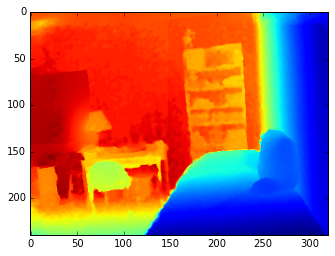

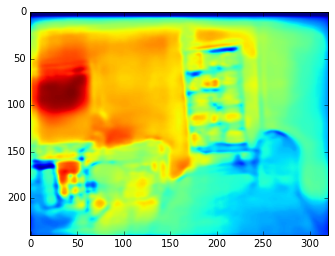

RMSE: 1.15806


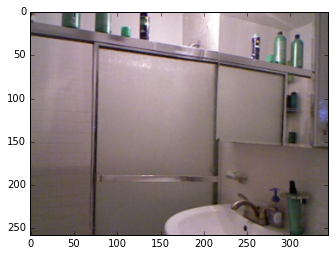

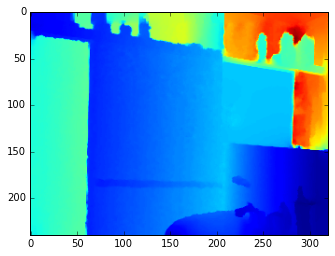

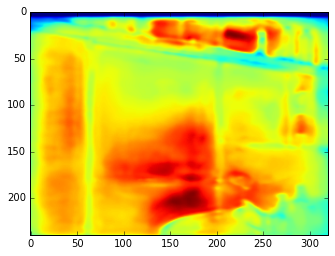

RMSE: 0.566062


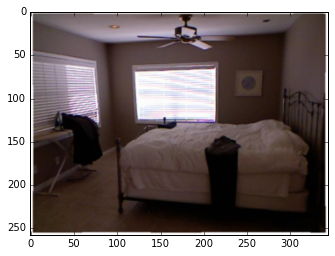

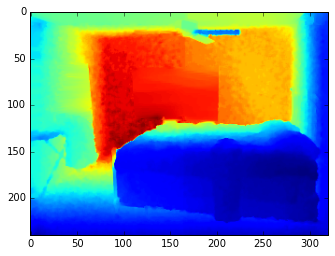

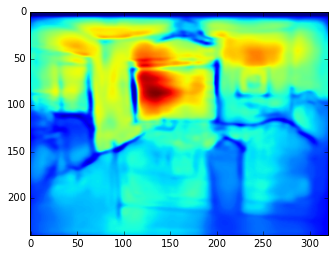

RMSE: 1.61313


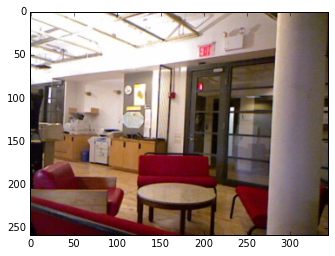

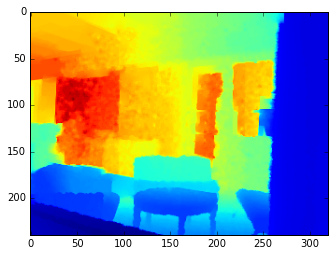

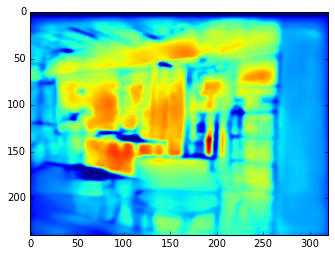

RMSE: 2.3911


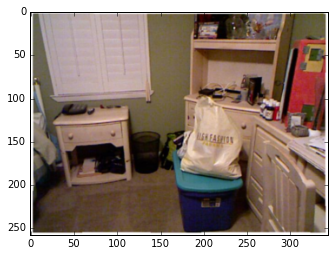

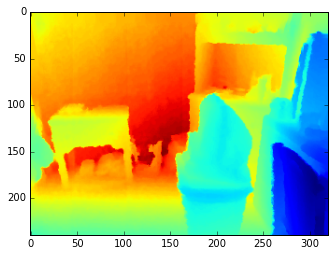

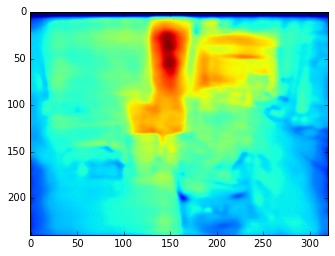

RMSE: 0.605907


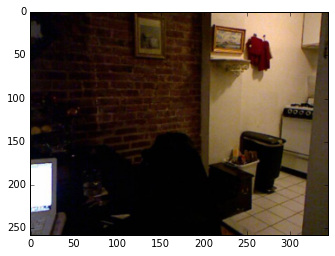

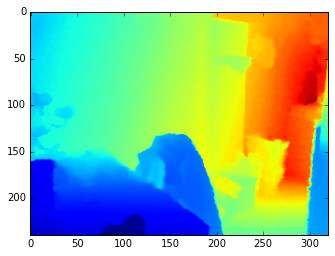

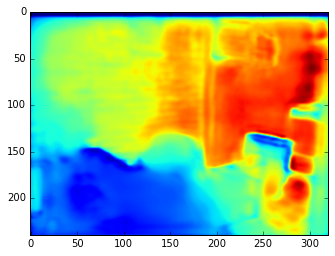

RMSE: 0.620136


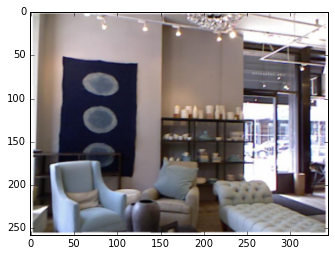

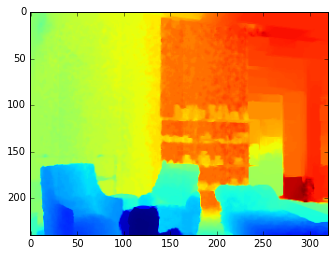

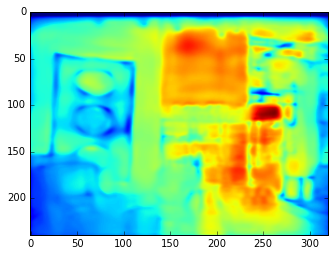

RMSE: 2.22487


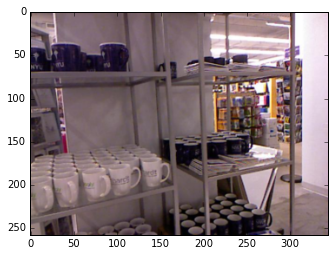

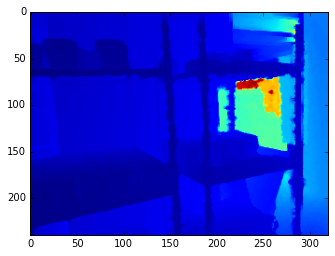

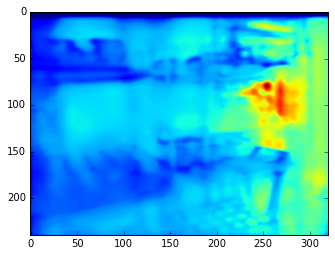

RMSE: 1.04586


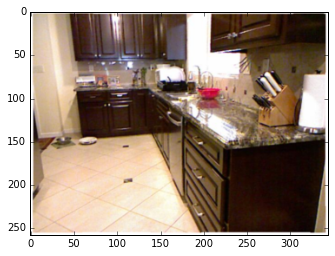

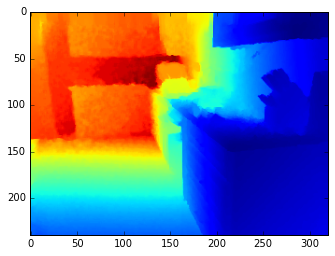

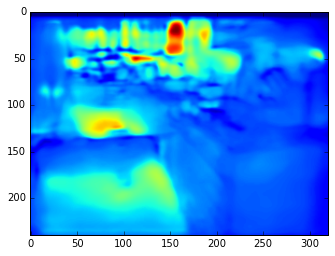

RMSE: 1.54275
Accumulated RMSE: 1.39864
Mean forward execution time (with Host -> GPU transfer): 0.068623


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from deepgraph.nn.core import Dropout
import time

plot = True
idx = 0
diffs = []
timings = []
Dropout.set_dp_off()
for image in images:
    tmp = image.astype(np.float32).copy()
    # Stochastic normalization
    tmp -= mean
    tmp *= 1.0 / 68.585375331125292
    # center crop
    cy = (tmp.shape[1] - 240 ) // 2
    cx = (tmp.shape[2] - 320 ) // 2
    tmp = tmp[:,cy:cy+240,cx:cx+320]
    # Infer and measure time
    start = time.time()
    res = g.infer([tmp.reshape((1,3,240,320))])["conv_23_with_bias"]
    end = time.time()
    timings.append(end - start)
    res = res.squeeze()
    res = np.exp(res)
    depth = depths[idx]
    tdepth = depth[cy:cy+240,cx:cx+320]

    if plot and idx % 20 == 0:
        
        plt.imshow(image.transpose((1,2,0)).astype(np.uint8))
        plt.show()
        plt.imshow(tdepth)
        plt.show()
        plt.imshow(res)
        plt.show()
        print "RMSE: " + str(np.sqrt(np.mean((res-tdepth)**2)))
        
    diffs.append(res - tdepth)
    
    idx += 1
    
diffs = np.array(diffs)
timings = np.array(timings)
rmse = np.sqrt(np.mean(diffs ** 2))
print "Accumulated RMSE: " + str(rmse)
print "Mean forward execution time (with Host -> GPU transfer): %f" % timings.mean()

# Infer random images from the internet

In [ ]:
import urllib, cStringIO
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from deepgraph.nn.core import Dropout


Dropout.set_dp_off()


urls = [
    'http://www.hotel-im-wasserturm.de/fileadmin/_processed_/csm_Deluxe_Doppelzimmer_2_6455fa52be.jpg',
    'http://hotel-airport-zuerich.dorint.com/fileadmin/_processed_/csm_ZRH_Zimmer_DZ_04_bc3a12f87e.jpg',
    'http://www.erlebnis-erlensee.de/images/bilder/partyservice/schnitzel.jpg',
    'http://www.hankewitz.com/wp-content/uploads/2012/12/bolognese21.jpg'
       ]
idx = 0
for URL in urls:
    file = cStringIO.StringIO(urllib.urlopen(URL).read())
    img = Image.open(file)
    i_s = img.resize((344,258))
    rs = np.array(i_s).transpose((2,0,1)).astype(np.float32)

    #mean = np.load("/home/ga29mix/nashome/data/nyu_depth_v2_combined_50.npy")
    
    rs -= mean
    rs *= 1.0 / 72.240064849107824
    # center crop
    cy = (rs.shape[1] - 240 ) // 2
    cx = (rs.shape[2] - 320 ) // 2
    rs = rs[:,cy:cy+240,cx:cx+320]
    res = g.infer([rs.reshape((1,3,240,320))])["conv_23_with_bias"]
    res = np.exp(res)
    
    plt.imshow(i_s)
    plt.show()
    plt.imshow(res.squeeze())
    plt.show()
    
    print res.max()
    # Store
    np.save("url_image_%i.npy" % idx, res)
    idx += 1


# Infer image from food data


In [ ]:
import urllib, cStringIO
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from deepgraph.nn.core import Dropout
import numpy as np

Dropout.set_dp_off()

data = np.load('/home/ga29mix/nashome/data/kinectv2_2016_03_30_13_33_25_bgr.npy')[:,:,0:3]
dd = np.load('/home/ga29mix/nashome/data/kinectv2_2016_03_30_13_33_25_depth.npy')

img = Image.fromarray(np.array(data[:,:,::-1]))
rs = img.resize((320,240))
mean = np.load("/home/ga29mix/nashome/data/nyu_depth_v2_combined_50.npy")
arr = np.array(rs).transpose((2,0,1)).astype(np.float32)
arr -= mean
arr *= 1.0 / 72.240064849107824
res = g.infer([arr.reshape((1,3,240,320))])["conv_23_with_bias"]
res = np.exp(res)
plt.imshow(img)
plt.show()
plt.imshow(res.squeeze())
plt.show()
plt.imshow(dd)
plt.show()
